First we import some crucial python modules that will allow us to analyse the data.

In [1]:
import uproot3
import uproot3_methods.classes.TLorentzVector as LVepm
import matplotlib.pyplot as plt
import time
import infofile
import numpy as np
import mplhep as hep
from scipy import stats

We need the following helper function to help use to calibrate the simualtion, we dont need to worry about what it actually does.

In [2]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

Here we are just defining the names of the files from where we will read the data and simulation. All data and MC samples should be downloaded to the local directory from https://vula.uct.ac.za/x/nF3H2b 
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/. The last file is the real collision data from ATLAS, the others are simulations of the physics processes we expect to have occured in the collisions. 

In [3]:
files = [
"mc_361106.Zee.4lep.root",
"mc_361107.Zmumu.4lep.root",
"mc_410000.ttbar_lep.4lep.root",
"mc_363490.llll.4lep.root",
"mc_363492.llvv.4lep.root",
"mc_363356.ZqqZll.4lep.root",    
"mc_345060.ggH125_ZZ4lep.4lep.root",
"mc_341964.WH125_ZZ4lep.4lep.root",
"mc_344235.VBFH125_ZZ4lep.4lep.root",
"mc_341947.ZH125_ZZ4lep.4lep.root",
"data.4lep.root"  
]

We need to select out the most interesting collisions from the data and simulation so that we can as clear as possible signal of Higgs boson production. The exact details of the cuts are not very important. In summary, we select collision in which four leptons (electrons or muons) have been detected. 

In [4]:
#------------DEFINING SOME VARIABLES AND OBJECTS FOR THE ANALYSIS----------------------------------------------------

lumi = 10#fb^-1
nBins = 34

minMass = 80
maxMass = 250

bins_ar = np.linspace(minMass, maxMass, num=(nBins+1))
mc_hist_list = []
sample_names = []

f = plt.figure()

H_125 = np.zeros([nBins])
H_bkg = np.zeros([nBins])

btagWP77 = 0.6459

#--------------------------------------------------------------------------------------------------------------------

for file in files: #looping over data and simulation files
    sample_name = file.split(".")[1] 
    sample_names.append(sample_name)
    tree = uproot3.open("Data/"+file)["mini"]

    mcWeight, SumWeights, XSection, trigM, trigE, scaleFactor_PILEUP, scaleFactor_ELE, scaleFactor_MUON,scaleFactor_LepTRIGGER, lep_type, lep_pt, lep_eta, lep_phi, lep_E, lep_charge, lep_etcone20, lep_ptcone30, jet_n, jet_pt, jet_eta, jet_phi, jet_E, jet_MV2c10 = tree.arrays(["mcWeight", "SumWeights", "XSection","trigM", "trigE","scaleFactor_PILEUP", "scaleFactor_ELE", "scaleFactor_MUON","scaleFactor_LepTRIGGER","lep_type","lep_pt", "lep_eta","lep_phi", "lep_E", "lep_charge", "lep_etcone20", "lep_ptcone30", "jet_n", "jet_pt", "jet_eta", "jet_phi","jet_E", "jet_MV2c10"], outputtype=tuple)
    print("File has been successfully opened!")
    
    leplv = LVepm.TLorentzVectorArray.from_ptetaphi(lep_pt, lep_eta, lep_phi, lep_E)

    lep_reliso_pt = (lep_ptcone30 / lep_pt)
    lep_reliso_et = (lep_etcone20 / lep_pt)
    sum_lep_type = lep_type.sum()
    
    jetlv = LVepm.TLorentzVectorArray.from_ptetaphi(jet_pt, jet_eta, jet_phi, jet_E)
    jetlv = jetlv[jet_MV2c10.argsort()]    
    tags = jet_pt[jet_MV2c10 > btagWP77]

    trig_cut = ( (trigM==1) | (trigE==1))
    lep_kinematics_cut  = ( (lep_pt.max() > 20000) & (lep_pt.min() > 7000) & (lep_eta.min() >-2.5) & (lep_eta.max() < 2.5))
    lep_type_cut  = ((sum_lep_type == 44) | (sum_lep_type == 48) | (sum_lep_type == 52))
    lep_iso_cut =  ((lep_reliso_pt.max() < 0.3) & (lep_reliso_pt.max() < 0.3))
    lept_count_cut = (leplv.counts ==4)
    lept_charge_cut = (lep_charge.sum()==0)
    
    # filtering events according to cuts above that select out interesting events
    event_cut = ( lep_kinematics_cut & lep_type_cut & lep_iso_cut  & lept_count_cut & lept_charge_cut)

    first_lep_p4 =  leplv[event_cut,0]
    second_lep_p4 = leplv[event_cut,1]
    third_lep_p4 =  leplv[event_cut,2]
    fourth_lep_p4 = leplv[event_cut,3]
    mcWeight = mcWeight[event_cut] 
    
    scaleFactor_PILEUP = scaleFactor_PILEUP[event_cut] 
    scaleFactor_ELE = scaleFactor_ELE[event_cut] 
    scaleFactor_MUON = scaleFactor_MUON[event_cut] 
    scaleFactor_LepTRIGGER = scaleFactor_LepTRIGGER[event_cut] 
    
    #construct 4-lepton system by adding 4-vectors of the leptons vectorially
    llll_p4 = first_lep_p4 + second_lep_p4 + third_lep_p4 + fourth_lep_p4  
    
    
    # make histograms of the m_llll distribution for simulation and data
    if(file.split("_")[0] == "mc"):
        finalWeight = get_xsec_weight(sample_name)*(mcWeight)*(scaleFactor_PILEUP)*(scaleFactor_ELE) *(scaleFactor_MUON)*(scaleFactor_LepTRIGGER)
        H, b = np.histogram(llll_p4.mass/1000.0, weights=finalWeight, bins=bins_ar)                        
        mc_hist_list.append(H)
        if("H125" in file):
            H_125 = np.add(H, H_125)
        else:
            #print("Sample Name = " + str(file) + " exp. num. events = " + str(np.sum(finalWeight)) )
            H_bkg = np.add(H, H_bkg)
    else:
        finalWeight = np.ones(len(mcWeight)) 
        sample_name = "Data (10 fb^-1)"
        H_data, b = np.histogram(llll_p4.mass/1000.0, weights=finalWeight, bins=bins_ar)

File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!
File has been successfully opened!


<Figure size 640x480 with 0 Axes>

With our events selected, we can compare our data with our expectations from theory. Our best theory of particle physics is known as the Standard Model, so the predictions here represent the expectations from the Standard Model after a simulation of how the ATLAS detector detects particles has been applied. 

Specifically, we plot a histogram of the number of collisions ("events") as a function of the mass of the four-lepton system. We use this mass because it distinguishes between the the Higgs signal, which has a peak at the higgs mass (125 GeV) and is zero elesehere, and the backgrounds which have a peak around 90 GeV and are flatter elsewhere.

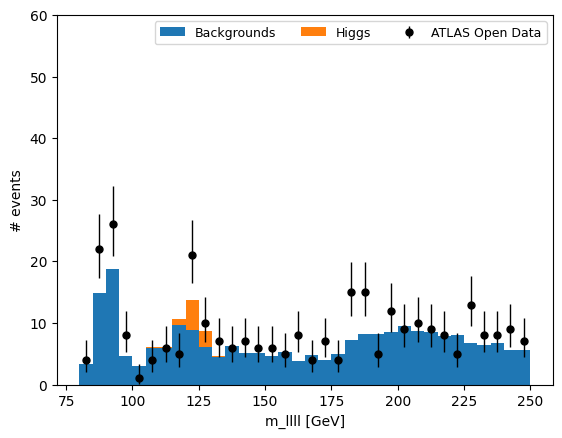

In [5]:
hep.histplot([H_bkg, H_125], bins=bins_ar, stack=True, label=["Backgrounds", "Higgs"], histtype='fill')
hep.histplot([H_data], bins=bins_ar, stack=False, yerr=True, histtype="errorbar", color="black",label="ATLAS Open Data")

plt.legend(loc=1, ncol=3, fontsize=9)
plt.xlabel("m_llll [GeV]")
plt.ylabel("# events")
plt.ylim([0.0, 60])
# plt.savefig('../Report/Plots/no_fit_hist.pdf')
plt.show()

We start by fitting one parameter at a time and comparing the two fits using a chi-squared function.

Our chi-squared function is defined in the usual way, noting that the denominator is simply the predicted mean as we assume the data to be Poisson distributed. 

In [6]:
def calcChiSq(obs, preds, numParams):
    #REPLACE THIS FUNCTION WITH A VALID CHI-SQUARED CALCULATION
    chiSq = np.sum( np.power( ( obs - preds ), 2) / ( preds ))
    ndf = len(obs) - numParams
    return chiSq, ndf

Here we find the chi-square/dof value for our model before any fitting happens

In [9]:
chi2_before_fit, dof_before_fit = calcChiSq(H_data, H_125 + H_bkg, 0)
print(f'Before fitting, chi-square/dof = {chi2_before_fit/dof_before_fit}')

Before fitting, chi-square/dof = 1.597845078902861


# Fitting s_s

In [12]:
s_s_ar = np.linspace(1.0, 3.0, 100) # array of s_s values we will investigate

chi2_ar = np.empty( len(s_s_ar) ) # empty array of that will hold the chi2 values we will calculate

minChi2 = 1000000
mindof = 1
bestFit_s_s = 0.0 #starting values for min chi2 and best value of s_s

for s_s in range(0, len(s_s_ar)): #looping over out s_s values 
    pred = (s_s_ar[s_s]*H_125) + (H_bkg) # generating a prediction according to this s_s
    chi2, dof = calcChiSq(H_data, pred, 1) # calculating chi2
    chi2_ar[s_s] = chi2 # adding chi2 value to chi2 array 
    if(chi2 < minChi2): # check if this is the lowest chi2 we have seen so far
         minChi2 = chi2 # update lowest chi2 value seen 
         mindof = dof   # update dof for lowest chi2
         bestFit_s_s = s_s_ar[s_s] # update value for best fit s_s

deltaChi2_ar = chi2_ar - minChi2 # make array of delta chi2 values

#we expect the chi2 vs. mZ curve to be quadratic, so let's fit that function to it.
z = np.polyfit(s_s_ar, deltaChi2_ar, 2) #"2" for a second-order polynomial
p = np.poly1d(z)

# we can display the estimated uncertianty on mZ via critical values of the delta chi-squared curve
y0 = 1.0
crit = (p - y0).roots # roots of the polynominal -1, i.e., the mz values where p = 1 

#shading in the confience interval band 
px=np.arange(crit[1],crit[0],0.001)
        
# fig, ax = plt.subplots()
# ax.plot(s_s_ar, deltaChi2_ar, 'k', linewidth=2, label="deltaChi2")
# ax.fill_between(px,p(px),alpha=0.5, color='g', label="uncertainty")

# plt.xlabel("s_s")
# plt.ylabel("delta chi-squared")
# plt.legend()
# plt.show()

print("Best fit value of s_s = " + str(round(bestFit_s_s, 3)) + " +/- " + str(round(np.abs(crit[0] - bestFit_s_s),2 )) )
print(f"minChi2/mindof: {minChi2/mindof}")

Best fit value of s_s = 2.01 +/- 0.76
minChi2/mindof: 1.5577434806307726


# Fitting s_b

In [13]:
s_b_ar = np.linspace(1.15, 1.4, 100)

chi2_ar = np.empty( len(s_b_ar) )

minChi2 = 1000000
mindof = 1
bestFit_s_b = 0.0

for s_b in range(0, len(s_b_ar)):
    pred = (H_125) + (s_b_ar[s_b]*H_bkg)
    chi2, dof = calcChiSq(H_data, pred, 1)
    chi2_ar[s_b] = chi2
    if(chi2 < minChi2):
        minChi2 = chi2
        mindof = dof
        bestFit_s_b = s_b_ar[s_b]
        
deltaChi2_ar = chi2_ar - minChi2

z = np.polyfit(s_b_ar, deltaChi2_ar, 2)
p = np.poly1d(z)

y0 = 1.0 # this is the value of the delta chi-squared function that defines the 68% CI for a one parameter fit.
         # we'll invetigate if this parmaeter makes sense in the final exercise.
crit = (p - y0).roots 

px=np.arange(crit[1],crit[0],0.001)
        
# fig, ax = plt.subplots()
# ax.plot(s_b_ar, deltaChi2_ar, 'k', linewidth=2, label="deltaChi2")
# ax.fill_between(px,p(px),alpha=0.5, color='g', label="uncertainty")
# plt.xlabel("s_b")
# plt.ylabel("delta chi-squared")
# plt.legend()
# plt.show()

print("Best fit value of s_b = " + str(round(bestFit_s_b, 3)) + " +/- " + str(round(np.abs(crit[0] - bestFit_s_b),3 )) )
print(f"minChi2/mindof: {minChi2/mindof}")

Best fit value of s_b = 1.302 +/- 0.076
minChi2/mindof: 1.0184456820283405


We can then move on to fitting them both at the same time.

# Fitting s_s and s_b

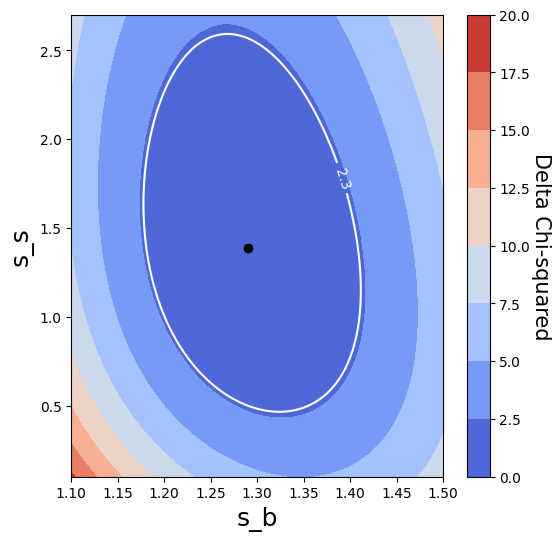

best-fit s_s = 1.3869 (+ 1.1556 /- 0.86667)
best-fit s_b = 1.2899 (+ 0.11717 /- 0.10909)
minChi2/mindof: 1.038884905786871


In [14]:
s_s_ar = np.linspace(0.1, 2.7, 100)
s_b_ar = np.linspace(1.1, 1.5, 100)

chi2_ar = np.empty( (len(s_s_ar), len(s_b_ar) ))

bestFit_s_s = 0.0
bestFit_s_b = 0.0

minChi2 = 1000000
mindof = 1

for s_s in range(0, len(s_s_ar)):
    for s_b in range(0, len(s_b_ar)):
        pred = (s_s_ar[s_s]*H_125) + (s_b_ar[s_b]*H_bkg)
        chi2, dof = calcChiSq(H_data, pred, 2)
        chi2_ar[s_s, s_b] = chi2 
        if(chi2 < minChi2):
            minChi2 = chi2
            mindof = dof
            bestFit_s_s = s_s_ar[s_s]
            bestFit_s_b = s_b_ar[s_b]

deltaChi2_ar = chi2_ar - minChi2
true_deltaChi2_ar = deltaChi2_ar    # For exercise 6

levels = [2.3] # this is the value of the delta chi-squared function that defines the 68% CI for a two parameter fit.
         # we'll invetigate if this parmaeter makes sense in the final exercise.
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

cfset = plt.contourf(s_b_ar, s_s_ar, deltaChi2_ar,  cmap='coolwarm')
cset = plt.contour(s_b_ar, s_s_ar, deltaChi2_ar, levels=levels, colors=['white'])

bf_point = plt.scatter(bestFit_s_b, bestFit_s_s, color='black')
bf_point_index = [np.where(true_deltaChi2_ar == 0)[0][0], np.where(true_deltaChi2_ar == 0)[1][0]]


cbar = plt.colorbar(cfset)
cbar.set_label('Delta Chi-squared', fontsize=15, rotation=270, labelpad=15)
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('s_b',fontsize=18)
ax.set_ylabel('s_s',fontsize=18)
# plt.savefig('../Report/Plots/two_fit_contour.pdf')
plt.show()

# Finding the bounds of the confidence interval for each parameter
s_s_bf_CI_left = s_s_ar[np.where(deltaChi2_ar[:,bf_point_index[1]] <= levels[0])[0][0]]
s_s_bf_CI_right = s_s_ar[np.where(deltaChi2_ar[:,bf_point_index[1]] <= levels[0])[0][-1]]
s_b_bf_CI_left = s_b_ar[np.where(deltaChi2_ar[bf_point_index[0],:] <= levels[0])[0][0]]
s_b_bf_CI_right = s_b_ar[np.where(deltaChi2_ar[bf_point_index[0],:] <= levels[0])[0][-1]]

s_s_bf_unc_left = np.abs(bestFit_s_s - s_s_bf_CI_left)
s_s_bf_unc_right = np.abs(bestFit_s_s - s_s_bf_CI_right)
s_b_bf_unc_left = np.abs(bestFit_s_b - s_b_bf_CI_left)
s_b_bf_unc_right = np.abs(bestFit_s_b - s_b_bf_CI_right)

#extract 2D result
print(f'best-fit s_s = {bestFit_s_s:.5} (+ {s_s_bf_unc_right:.5} /- {s_s_bf_unc_left:.5})')
print(f'best-fit s_b = {bestFit_s_b:.5} (+ {s_b_bf_unc_right:.5} /- {s_b_bf_unc_left:.5})')
print(f'minChi2/mindof: {minChi2/mindof}')

With these s_s and s_b values, we can have a look at the model and how it compares to the data

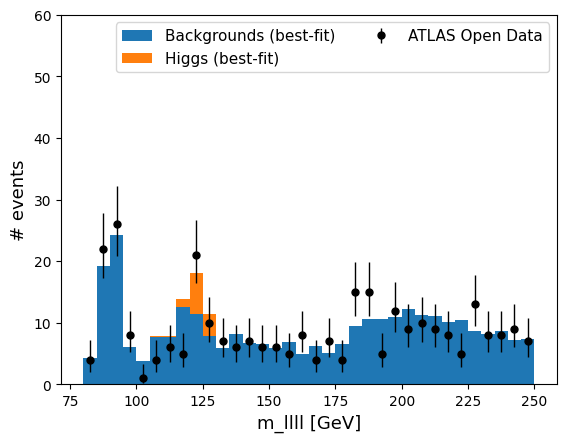

In [15]:
f = plt.figure()

H_125_bf = bestFit_s_s*H_125
H_bkg_bf = bestFit_s_b*H_bkg

hep.histplot([H_bkg_bf, H_125_bf], bins=bins_ar, stack=True, label=["Backgrounds (best-fit)", "Higgs (best-fit)"], histtype='fill')
hep.histplot([H_data], bins=bins_ar, stack=False, yerr=True, histtype="errorbar", color="black",label="ATLAS Open Data")
plt.legend(loc=1, ncol=2, fontsize=11)
plt.xlabel("m_llll [GeV]", fontsize=13)
plt.ylabel("# events", fontsize=13)
plt.ylim([0.0, 60])
# plt.savefig('../Report/Plots/two_fit_hist.pdf')
plt.show()

# Goodness of fit
Here we can generate some toy distributions according to our model and see how the chi-square value for our data compares to that distribution

chi2 value of ATLAS Open data is = 33.24431698517987


<Figure size 640x480 with 0 Axes>

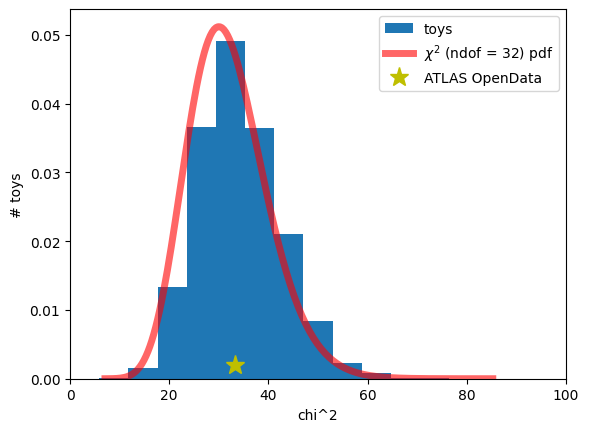

In [16]:
# generate the chi-2 distribution of N toy experiments based on the fitted model 
# assume a gaussian-distributed bin height with mean = model pred. and sigma equal root model pred
# what then is the p-value of the data with respect to the distribution?
    
#function to generate a toy histogram given the mean for each bin and assuming the data is
# gaussian-distrubtu
def generate_toy(means): 
        toy = np.empty(len(means))
        for i in range(0, len(means)):
            toy_bin = np.random.normal(means[i], np.sqrt(means[i]), 1)
            toy[i] = toy_bin
        #print("toy = " + str(toy))
        return toy

ntoys = 10000 # start with a small number, increase when you undertsand your results

means = H_bkg_bf + H_125_bf # take the results of the fit as the means of the fitted model

#print("means" + str(means))

chi2_toys = np.empty(ntoys)

for t in range(0, ntoys):
    toy = generate_toy(means) 
    chi2_toys[t] = calcChiSq(toy, means, 0)[0]
    #print("chi2 " + str(chi2_toys[t]))
    
plt.figure()
fig, ax1 = plt.subplots()

#plot distribtion of chi-squared values from toys
bins_ar = np.linspace(0.0, 200, num=(nBins+1))
chi2Hist, chi2bins = np.histogram(chi2_toys, bins=bins_ar, density=True)                        
hep.histplot([chi2Hist], bins=chi2bins, histtype='fill', label="toys")

#plot expected distrutuon of chi-squared values from theory - chi-squared distribtuions with ndof = nbins -2
df = nBins - 2
x = np.linspace(stats.chi2.ppf(0.000001, df), stats.chi2.ppf(0.999999, df), 200)
label = '$\chi^{2}$ (ndof = ' + str(df) + ') pdf'
ax1.plot(x, stats.chi2.pdf(x, df), 'r-', lw=5, alpha=0.6, label=label)

# overlay the chi2 squared value from the ATLAS OpenData
chi2_data = calcChiSq(H_data, means, 0)[0]
plt.plot(chi2_data,0.002 , 'y*', ms=14, label='ATLAS OpenData')
plt.legend()
plt.xlabel("chi^2")
plt.ylabel("# toys")
plt.xlim(0,100)

print("chi2 value of ATLAS Open data is = " + str(chi2_data))

Related to that is the p-value. We can find it for the model before and after fitting, using the chi-square cumulative distribution function.

In [17]:
pVal_before_fit = 1 - stats.chi2.cdf(chi2_before_fit, dof_before_fit)    # No parameters so dof is just nBins

print(f'p value before fitting: {pVal_before_fit:.5}')

x = np.linspace(stats.chi2.ppf(0.000001, df), stats.chi2.ppf(0.999999, df), 200)
pVal = 1 - stats.chi2.cdf(chi2_data, df)

print(f'p value with fitting: {pVal:.5}')

p value before fitting: 0.014877
p value with fitting: 0.40642


Now we investigate the usage of a critical value of 2.3.

In [ ]:
d_arr = np.linspace(1, 5, 40)
N_toys = 500
model_means = H_125_bf + H_bkg_bf
min_chi_sq_arr = np.zeros( (len(d_arr), N_toys) )
min_dof_arr = np.zeros( (len(d_arr), N_toys) )

fracs = np.zeros(len(d_arr))

for d_index, d in enumerate(d_arr):
    num_within_d = 0
    for t in range(N_toys):
        chi2_ar_toy = np.empty( (len(s_s_ar), len(s_b_ar) ))

        H_toy = generate_toy(model_means)

        bestFit_s_s_toy = 0.0
        bestFit_s_b_toy = 0.0

        minChi2 = 1000000
        mindof = 1

        for s_s in range(0, len(s_s_ar)):
            for s_b in range(0, len(s_b_ar)):
                pred = (s_s_ar[s_s]*H_125) + (s_b_ar[s_b]*H_bkg)
                chi2, dof = calcChiSq(H_toy, pred, 2)
                chi2_ar_toy[s_s, s_b] = chi2 
                if(chi2 < minChi2):
                    minChi2 = chi2
                    mindof = dof
                    bestFit_s_s_toy = s_s_ar[s_s]
                    bestFit_s_b_toy = s_b_ar[s_b]

        deltaChi2_ar_toy = chi2_ar_toy - minChi2

        if (deltaChi2_ar_toy[bf_point_index[0], bf_point_index[1]] <= d):
            num_within_d += 1


    fracs[d_index] = num_within_d / N_toys


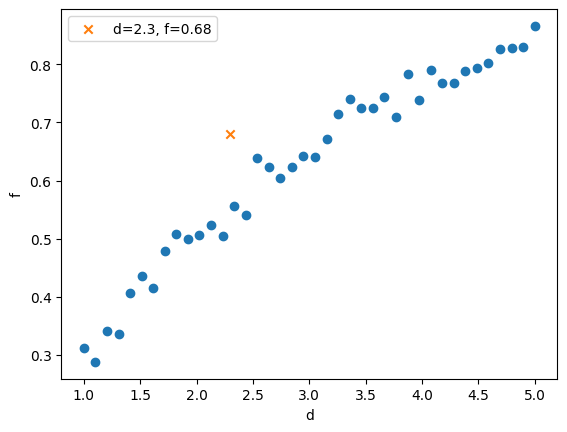

In [24]:
frac_import = np.load('fracs.npy',)
plt.scatter(d_arr, frac_import)
plt.xlabel('d')
plt.ylabel('f')
plt.scatter([2.3], [0.68], label='d=2.3, f=0.68', marker='x')
plt.legend()
plt.savefig('../Report/Plots/d_f.pdf')